<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Oct 29 06:39:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 61%   79C    P0    42W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install -q git+git://github.com/fastai/fastcore.git
# !pip install -q git+git://github.com/fastai/fastai.git
# !pip install -q git+git://github.com/lgvaz/faststyle.git

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from faststyle import *

In [ ]:
# try:
#   from google.colab import drive
#   drive.mount('/content/gdrive', force_remount=True)
#   root_dir = Path('/content/gdrive/My Drive/')
# except ImportError:
#   root_dir = Path('.')

In [ ]:
source = untar_data(URLs.COCO_SAMPLE)

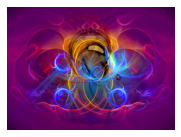

In [ ]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L('abstract_digital1.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [ ]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

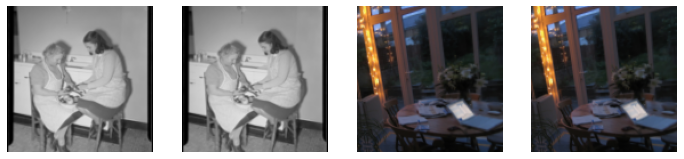

In [ ]:
dls = dblock.dataloaders(source, bs=2)
dls.show_batch(max_n=3)

In [ ]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [ ]:
m = TransformerNet()
cbs = [SaveModelCallback()]
loss_func = FastStyleLoss(stl_w=3e5, tv_w=300)
learn = style_learner(dls, m, get_feats, style_fns, loss_func=loss_func, cbs=cbs)

In [ ]:
# learn.path = root_dir/'dl/faststyle'

In [ ]:
learn.path

Path('.')

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-3, pct_start=.9)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,18.952221,23.278978,6.048449,16.435955,0.794560,14:18


Better model found at epoch 0 with valid_loss value: 23.27897834777832.


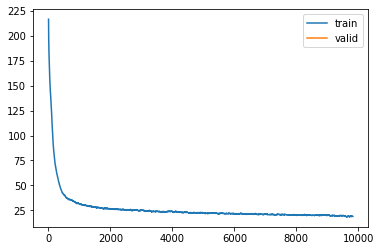

In [ ]:
learn.recorder.plot_loss()

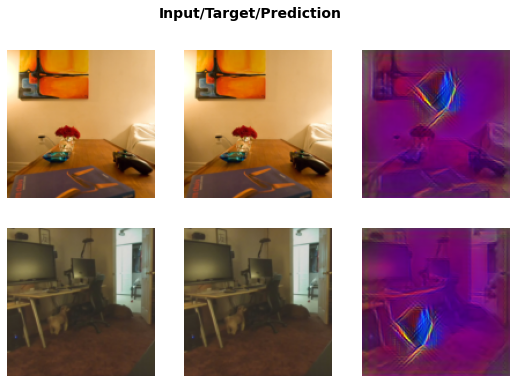

In [ ]:
learn.show_results()

In [ ]:
learn.save('tn-abstractd-128')

Path('models/tn-abstractd-128.pth')